<a href="https://colab.research.google.com/github/developeravsk/Tic-Tac-Toe-Reinforcement-Learning/blob/main/Reinforcement_learning_Tic_Tac_Toe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement learning exercise: tic-tac-toe with Q-learning

Today we'll get an understanding of one of the common methods for reinforcement learning
when the state is observable and relatively small but the state transition function and
reward function are unknown.

We'll play two tic-tac-toe agents against each other. They will start out with random
policies and gradually improve them.

Even though tic-tac-toe has a known state transition function and a known reward function,
we'll pretend that's not the case. We'll use Q-learning:

**Output**: action value function $Q$

**Steps**:

1. Initialize $Q$ arbitrarily, e.g., to 0, and set action value for terminal states to 0.
2. For each episode do
   1. Initialize state $s$
   2. For each step of episode, state $s$ is not terminal do
      1. $a \leftarrow$ action for $s$ derived by $Q$, e.g., using $\epsilon$-greedy
      2. Take action $a$ and observe $r$ and $s'$
      3. $Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]$
      
For tic-tac-toe, though, to get our agent to learn, it needs an opponent.
So we will interleave optimization of player X with that or player O. Both X and O will have their own Q
table and their own reward function.

First, some functions that will be needed:

In [1]:
import itertools
import re
import random
import numpy as np

# Enumerate all possible states ('         ', '    X    ', etc.)

def get_all_states():
    symbols = [' ', 'X', 'O']
    return [''.join(i) for i in itertools.product(symbols, repeat = 9)]

# Determine whether state is win for X

def is_win_X(s):
    return bool(re.search('^XXX', s) or re.search('^...XXX', s) or re.search('^......XXX', s) or \
                re.search('^X..X..X', s) or re.search('^.X..X..X', s) or re.search('^..X..X..X', s) or \
                re.search('X...X...X', s) or re.search('..X.X.X', s))

# Determine whether state is win for O

def is_win_O(s):
    return bool(re.search('^OOO', s) or re.search('^...OOO', s) or re.search('^......OOO', s) or \
                re.search('^O..O..O', s) or re.search('^.O..O..O', s) or re.search('^..O..O..O', s) or \
                re.search('O...O...O', s) or re.search('  O.O.O', s))

# Determine whether state is draw

def is_draw(s):
    return bool(re.search('^[OX][OX][OX][OX][OX][OX][OX][OX][OX]', s))

# Find all terminal states

def get_terminal_states(all_states):
    terminal_states = {}
    for s in all_states:
        if is_win_X(s) or is_win_O(s) or is_draw(s):
            terminal_states[s] = True
        else:
            terminal_states[s] = False
    return terminal_states

# Extend state s with action a for player p
# s: element of [ XO]^9
# a: integer 0 to 8
# p: 'X' or 'O'

def extend(s, a, p):
    if s[a] != ' ':
        raise Exception('space already taken!')
    return s[:a] + p + s[a+1:]

# Return the set of legal actions for state s as an array of inidices 0 to 8

def valid_actions(s):
    return [pos for pos, char in enumerate(s) if char == ' ']

# Initialize and return an action value table Q[s,a] for all possible state-action pairs

def init_q():
    Q = {}
    for s in all_states:
        for a in range(9):
            Q[s,a] = 0
    return Q

# Select an action to perform in state s for player p according to action value Q

def epsilon_greedy(s, Q, epsilon):
    actions = valid_actions(s)
    if len(actions) == 0:
        return None
    if random.random() < epsilon:
        # With probility epsilon, sample uniformly from the valid actions
        return random.choice(actions)
    else:
        # With probability 1-epsilon, select current best actions (selecting randomly for any ties)
        values = list(map(lambda a: Q[s,a], actions))
        actions_max_value = np.argwhere(values == np.max(values)).flatten()
        return actions[random.choice(actions_max_value)]

# Get reward for entering state s for player p

def reward(s, p):
    if not terminal_states[s]:
        return 0
    elif is_win_X(s):
        return 100 if p=='X' else 0
    elif is_win_O(s):
        return 100 if p=='O' else 0
    elif is_draw(s):
        return 50
    raise Exception('unexpected terminal state ' + s)
            
# Perform action a in state s and return new state and reward

def perform(s, a, p, terminal_states, Q_opponent):
    new_state = extend(s, a, p)
    if terminal_states[new_state]:
        return new_state, reward(new_state, p)
    else:
        # Assume opponent takes pure greedy step (epsilon=0)
        opponent_action = epsilon_greedy(new_state, Q_opponent, 0)
        new_state = extend(new_state, opponent_action, ('O' if p=='X' else 'X'))
        if terminal_states[new_state]:
            return new_state, reward(new_state, p)
        else:
            return new_state, 0

Now that we have all the utility functions in place, here's code to run Q-learning on a series of games.
First X plays against the naive (initially random) O and optimizes its action value table a bit if it gets
positive feedback (a win or a draw). Then O plays against the slightly optimized X, optimizing its action
value table a bit. This continues for some number of iterations.

I found that player O when optimized for 100,000 games in this way played about as well as a 3-year-old,
making mistakes sometimes. After 1,000,000 games, however, the player is unbeatable.

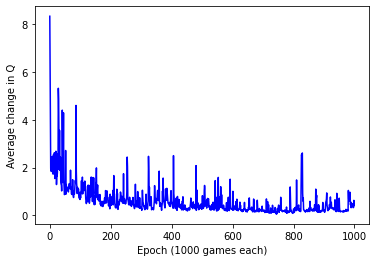

In [2]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

# Run Q learning for some number of games. We'll alternate between optimizing
# X and O as they play each other.

epsilon = 0.1
all_states = get_all_states()
terminal_states = get_terminal_states(all_states)
N_games = 1000000
alpha = 0.1
gamma = 0.9

# 1. Initialize Q
Q_X = init_q()
Q_O = init_q()

# 2. For each episode
changes_Q = []
report_interval = 1000
for g in range(0,N_games):
    
    if g % report_interval == 0:
        change_Q = 0
    
    # Play once with X as learner:
    # 2.1 Initialize state
    s = '         '
    # 2.2 For each step of episode, not terminal state
    while not terminal_states[s]:
        # 2.2.1 Get epsilon greedy action
        a = epsilon_greedy(s, Q_X, epsilon)
        # 2.2.2 Take action a, observing s', r
        s_prime, r = perform(s, a, 'X', terminal_states, Q_O)
        # 2.2.3 Q(s,a) <- Q(s,a) + alpha [r + gamma max_a' Q(s',a') - Q(s,a)]
        a_prime = epsilon_greedy(s_prime, Q_X, 0)
        max_value_s_prime = 0 if a_prime == None else Q_X[s_prime, a_prime]
        new_Q = Q_X[s, a] + alpha * (r + gamma * max_value_s_prime - Q_X[s, a])
        change_Q = change_Q + abs(Q_X[s, a] - new_Q)
        Q_X[s, a] = new_Q
        # Set up for next iteration
        s = s_prime
            
    # Play once with O as learner:
    s = '         '
    opponent_a = epsilon_greedy(s, Q_X, 0)
    s = extend(s, a, 'X')
    while not terminal_states[s]:
        a = epsilon_greedy(s, Q_O, epsilon)
        s_prime, r = perform(s, a, 'O', terminal_states, Q_X)
        a_prime = epsilon_greedy(s_prime, Q_O, 0)
        max_value_s_prime = 0 if a_prime == None else Q_O[s_prime, a_prime]
        new_Q = Q_O[s, a] + alpha * (r + gamma * max_value_s_prime - Q_O[s, a])
        change_Q = change_Q + abs(Q_O[s, a] - new_Q)
        Q_O[s, a] = new_Q
        s = s_prime
        
    if g % report_interval == report_interval - 1:
        changes_Q.append(change_Q / report_interval)
        plt.clf()
        plt.plot(changes_Q, 'b-')
        plt.xlabel('Epoch (%d games each)' % (report_interval))
        plt.ylabel('Average change in Q')
        display.display(plt.gcf())
        display.clear_output(wait=True)


Here's some code to let you play against the optimized O player. You can write your own
version to play against the optimized X player.

In [5]:
# Play the optimized agent

def print_board(s):
    print('%s|%s|%s' % (s[0], s[1], s[2]))
    print('-+-+-')
    print('%s|%s|%s' % (s[3], s[4], s[5]))
    print('-+-+-')
    print('%s|%s|%s' % (s[6], s[7], s[8]))

s = '         '
while not terminal_states[s]:
    print_board(s)
    actions = valid_actions(s)
    action = None
    while not action in actions:
        print('Enter your move (', actions, '):')
        action = int(input())
        if not action in actions:
            print('Invalid move!')
    s, r = perform(s, action, 'X', terminal_states, Q_O)

print_board(s)
if is_win_X(s):
    print('You win!')
elif is_win_O(s):
    print('You lose!')
else:
    print('Draw!')


 | | 
-+-+-
 | | 
-+-+-
 | | 
Enter your move ( [0, 1, 2, 3, 4, 5, 6, 7, 8] ):
0
X| | 
-+-+-
 |O| 
-+-+-
 | | 
Enter your move ( [1, 2, 3, 5, 6, 7, 8] ):
2
X|O|X
-+-+-
 |O| 
-+-+-
 | | 
Enter your move ( [3, 5, 6, 7, 8] ):
7
X|O|X
-+-+-
O|O| 
-+-+-
 |X| 
Enter your move ( [5, 6, 8] ):
5
X|O|X
-+-+-
O|O|X
-+-+-
 |X|O
Enter your move ( [6] ):
6
X|O|X
-+-+-
O|O|X
-+-+-
X|X|O
Draw!


That's it! You have seen the amazing power of learning from scratch via reinforcement.

Note the limitations, however:
1. The state is fully observable
2. All possible states can be exhaustively represented in tabular form
3. All possible state-action pairs fit in memory
4. It must be possible for the agent to try a lot of possibilities, meaning we need a really fast simulator for the environment.

If the state is not observable, Q-learning in this for is not usable.

Also, if we can't accurately and quickly simulate the agent's environment, we can't use Q-learning.

Finally, the size of the state table is the biggest limitation.

The state table is going to grow exponentially in the number of dimensions. For example, the number
of board states in chess (including impossible states) is $6^{64}$. With 16 possible moves and a 4-byte float for each state-action pair, the Q table would
be $4 \cdot 8 \cdot 6^{64} \approx 2^{170}$ bytes! Noboody has that much RAM, and the sun will probably eat
the Earth before you could get accurate Q values for every one of the valid state-action pairs. Go is even worse: a 19x19 board's Q table would require about $2^{583}$ bytes!

So the first thing we need to understand is how to approximate $Q[s,a]$ rather than enumerate it in a table.